### **KAGGLE - WHATS COOKING?**

<br>

This ongoing Kaggle competition serves us a JSON/dict style dataset, with each entry containing a given cuisine type, and within that, a list of ingredients.  The challenge is to classify and predict the cuisine types correctly using the ingredient list given.
<br><br>
So, is this an NLP problem, really? It depends how we look at it :)<br><br>
Let's address this in 2 ways, first by viewing the problem as structured and then move on to a series of unstructured/NLP approaches.  **We are likely to see that NLP techniques will prevail**

In [190]:
import numpy as np
import pandas as pd
import os
import re
import time
import shutil
import json
import random
import copy
import zipfile
import pickle

import datetime
from datetime import datetime as dt

import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model,save_model,load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization

from itertools import product

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import catboost
from catboost import CatBoostClassifier as cbc,CatBoostRegressor as cbr

AUTOTUNE = tf.data.AUTOTUNE

In [192]:
sns.set_theme()

VAL_FRAC = 0.1
#if 'AUC' not in globals(): 
my_auc = AUC() # store the AUC method, being sure to only do so once
MODEL_PATH = 'models/'
MODEL_PATH_TEST = 'models_test/'
HISTORY_PATH = 'model_data/model_history.csv'
HISTORY_PATH_TEST = 'model_data/model_history_test.csv'
SEED = 89 # this must remain the same for dataset generation consistency, as pandas uses the numpy seed to dictate its own randomness
VOCAB = 10000

# initialize a global store for model histories, and re-fetch its contents whenever required 
def model_history(path=HISTORY_PATH):
    return pd.read_csv(path)

####
#### **READ IN AND EXPLORE DATA**

Lorem ipsum

In [59]:
with open('data/train.json','r') as f: train = json.load(f)
with open('data/test.json','r') as f: test = json.load(f)

In [60]:
np.random.seed(SEED)
train_df = pd.DataFrame.from_dict(train).sample(frac=1).reset_index(drop=True)
test_df = pd.DataFrame.from_dict(test)

train_df.head()

,id,cuisine,ingredients
0,21245,chinese,"[soy sauce, sesame oil, garlic cloves, boneles..."
1,23955,mexican,"[pepper, 2% reduced-fat milk, enchilada sauce,..."
2,27751,greek,"[fresh dill, dry white wine, dill tips, ground..."
3,27929,mexican,"[chili powder, cumin, garlic powder, all-purpo..."
4,25449,indian,"[cauliflower, yoghurt, teas, white pepper]"


In [61]:
groups_df = pd.DataFrame.from_dict([Counter(train_df['cuisine'])]).transpose().reset_index()
groups_df['share'] = groups_df[0]/sum(groups_df[0])
groups_df

,index,0,share
0,chinese,2673,0.067205
1,mexican,6438,0.161865
2,greek,1175,0.029542
3,indian,3003,0.075502
4,italian,7838,0.197063
5,french,2646,0.066526
6,spanish,989,0.024865
7,thai,1539,0.038694
8,japanese,1423,0.035777
9,cajun_creole,1546,0.038870


####

#### **A STRUCTURED DATA APPROACH?**


Lorem ipsum

In [6]:
foods = []
for i in train:
    foods = foods+i['ingredients']

KeyboardInterrupt: 

In [7]:
food_counts = Counter(foods)

In [52]:
food_counts = pd.DataFrame.from_dict([food_counts]).transpose().reset_index()
food_counts.columns = ['food','freq']
food_counts = food_counts.sort_values(by='freq',ascending=False).reset_index(drop=True)
food_counts['cum_sum'] = np.cumsum(food_counts['freq'])/sum(food_counts['freq'])
food_counts

,food,freq,cum_sum
0,salt,18049,0.042143
1,olive oil,7972,0.060758
2,onions,7972,0.079372
3,water,7457,0.096784
4,garlic,7380,0.114016
...,...,...,...
6709,sauerkraut juice,1,0.999991
6710,no-calorie sweetener,1,0.999993
6711,Bob Evans Italian Sausage,1,0.999995
6712,extra firm silken tofu,1,0.999998


In [56]:
for i,j in enumerate(food_counts['food'][:len(food_counts)//4]):
    if i%200 == 0: print(i)
    train_df[j] = train_df['ingredients'].apply(lambda x: 1 if j in x else 0)
    test_df[j] = test_df['ingredients'].apply(lambda x: 1 if j in x else 0)

0
200
400
600
800
1000
1200
1400
1600


In [61]:
train_df.head()

,id,cuisine,ingredients,salt,olive oil,onions,water,garlic,sugar,garlic cloves,...,frozen peas and carrots,grated romano cheese,raspberry jam,chicken sausage,soybean sprouts,gelatin,yellow miso,browning,full fat coconut milk,tortellini
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,22213,indian,"[water, vegetable oil, wheat, salt]",1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pca = PCA(n_components=2)

In [66]:
pca = PCA().fit(train_df.iloc[:,3:])

Text(0, 0.5, 'cumulative explained variance')

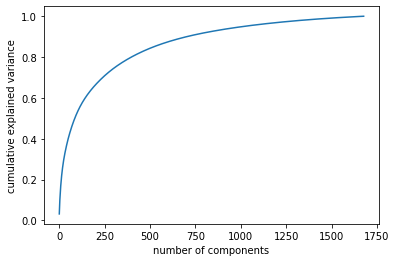

In [68]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [72]:
pca = PCA(n_components=1000).fit(train_df.iloc[:,3:])

In [76]:
x_train = pca.transform(train_df.iloc[:,3:])

In [169]:
y_train = LabelEncoder().fit(train_df['cuisine']).transform(train_df['cuisine'])

In [79]:
x_train.shape

(39774, 1000)

In [171]:
type(y_train)

numpy.ndarray

In [47]:
list(np.quantile(food_counts['cum_sum'],[(c+1)/20 for c in range(20)]))

[0.7303660031521803,
 0.8474202323273597,
 0.8992669429688869,
 0.9291553324382698,
 0.948019380071216,
 0.9609610647364427,
 0.9700134259529508,
 0.9767915474870119,
 0.9818553499503824,
 0.9858198587356255,
 0.988912381063569,
 0.9912635572937949,
 0.9931350183877181,
 0.9947024692078688,
 0.9960813729496235,
 0.9968650983596987,
 0.997648823769774,
 0.9984325491798494,
 0.9992162745899247,
 1.0]

In [ ]:
y_train = y_train.transform(train_df['cuisine'])

In [91]:
data = pd.concat([pd.DataFrame(x_train),pd.DataFrame(y_train)],axis=1)

In [93]:
data.columns = list(data.columns)[:-1]+['y']
data.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,y
0,-0.159263,-0.407133,0.220931,-0.649512,0.359965,-0.290378,-0.286225,-0.076494,0.085529,-0.075510,...,-0.001949,0.004705,0.005596,-0.013538,0.022723,0.005146,-0.013412,-0.014088,0.005767,6
1,0.420856,0.444814,-0.063564,-0.141336,-0.145700,-0.387407,0.399827,0.617806,0.165733,0.093660,...,0.002379,-0.001673,0.005873,-0.009391,0.010649,-0.010023,-0.001663,-0.005716,0.002292,16
2,0.513997,0.591359,0.181733,-0.367781,0.153239,-0.480389,-0.238855,-0.300040,1.017442,0.032789,...,-0.011642,-0.007078,0.017455,-0.022121,0.043510,0.031083,-0.006777,0.022490,0.007900,4
3,0.291077,0.377957,0.400576,0.554754,-0.031608,-0.155512,-0.455843,0.470760,-0.027952,0.343575,...,0.003110,0.003404,0.004059,-0.004057,-0.005545,0.007067,0.011357,-0.004702,-0.010772,7
4,1.062523,0.084683,0.518266,0.221745,-1.037049,0.110613,-0.567018,0.173270,-0.157711,0.112519,...,-0.000794,0.021369,-0.024780,0.000521,-0.039328,-0.046987,0.022359,0.040351,-0.041535,7


In [103]:
def cbc_wrapper(data, target='y', test_frac=0.1, loss_function='MultiClass', verbose=True, eval_metric='MultiClass', rounds=1, epochs=200, depth=5, learning_rate=0.01):
    data_source = 'kaggle_mercedez_benz_regression'

    types_df = pd.DataFrame(data.dtypes).reset_index().reset_index()
    types_char = types_df[types_df[0]=='object']
    types_float = types_df[types_df[0]=='float64']
    types_int = types_df[types_df[0]=='int64']
    ordcols = list(types_char['index'])+list(types_float['index'])+list(types_int['index'])
    ordindices = list(types_char['level_0'])
    data = data[ordcols]
    data[list(types_char['index'])] = data[list(types_char['index'])].astype(str)

    my_features = data.filter(regex='^(?!'+target+')')
    feature_names = list(my_features.columns.values)

    models, model_paths = [], []
    for i in range(rounds):
        data_shuffled = data.loc[:,:].copy().sample(frac=1)
        x_val = data_shuffled.iloc[:int(len(data_shuffled)*test_frac),:]
        y_val = x_val.pop(target)
        x_train = data_shuffled.iloc[int(len(data_shuffled)*test_frac):,:]
        y_train = x_train.pop(target)

        models.append(cbc(loss_function=loss_function,verbose=verbose,eval_metric=eval_metric,metric_period=1,
                          iterations=epochs,depth=depth,learning_rate=learning_rate,od_wait=20))
        models[-1].fit(x_train,y_train,eval_set=(x_val,y_val),cat_features=list(range(0,len(ordindices)-0)),metric_period=1)
        y_pred = models[-1].predict(x_val,verbose=True)
    return models,y_val,y_pred

In [104]:
model = cbc_wrapper(data)

0:	learn: 2.9694028	test: 2.9694852	best: 2.9694852 (0)	total: 1.05s	remaining: 3m 29s
1:	learn: 2.9439771	test: 2.9441327	best: 2.9441327 (1)	total: 2.14s	remaining: 3m 32s
2:	learn: 2.9189318	test: 2.9192702	best: 2.9192702 (2)	total: 3.19s	remaining: 3m 29s
3:	learn: 2.8972895	test: 2.8978431	best: 2.8978431 (3)	total: 4.24s	remaining: 3m 27s
4:	learn: 2.8757814	test: 2.8765937	best: 2.8765937 (4)	total: 5.28s	remaining: 3m 25s
5:	learn: 2.8546014	test: 2.8555008	best: 2.8555008 (5)	total: 6.31s	remaining: 3m 24s
6:	learn: 2.8342744	test: 2.8352904	best: 2.8352904 (6)	total: 7.37s	remaining: 3m 23s
7:	learn: 2.8159387	test: 2.8169765	best: 2.8169765 (7)	total: 8.43s	remaining: 3m 22s
8:	learn: 2.7980508	test: 2.7991083	best: 2.7991083 (8)	total: 9.46s	remaining: 3m 20s
9:	learn: 2.7803425	test: 2.7815869	best: 2.7815869 (9)	total: 10.5s	remaining: 3m 19s
10:	learn: 2.7638274	test: 2.7652317	best: 2.7652317 (10)	total: 11.6s	remaining: 3m 18s
11:	learn: 2.7473902	test: 2.7490503	best

In [110]:
model[0][-1].save_model('model_data/catboost_1.json',format='json')

In [118]:
preds = pd.concat([pd.DataFrame(model[1]).reset_index(drop=True),pd.DataFrame(model[2])],axis=1)

In [119]:
model[2]

array([[ 9],
       [ 9],
       [ 9],
       ...,
       [ 5],
       [13],
       [ 9]])

In [122]:
preds['match'] = preds.apply(lambda r: 1 if r['y']==r[0] else 0,axis=1)

In [ ]:
## Try Clustering methods just ot see how good or bad they are (to do)

In [125]:
sum(preds['match'])/len(preds)

0.4659290922806135

In [13]:
for i in train:
    for j in i['ingredients']:
        i[j] = 1
        
train

[{'id': 10259,
  'cuisine': 'greek',
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles'],
  'romaine lettuce': 1,
  'black olives': 1,
  'grape tomatoes': 1,
  'garlic': 1,
  'pepper': 1,
  'purple onion': 1,
  'seasoning': 1,
  'garbanzo beans': 1,
  'feta cheese crumbles': 1},
 {'id': 25693,
  'cuisine': 'southern_us',
  'ingredients': ['plain flour',
   'ground pepper',
   'salt',
   'tomatoes',
   'ground black pepper',
   'thyme',
   'eggs',
   'green tomatoes',
   'yellow corn meal',
   'milk',
   'vegetable oil'],
  'plain flour': 1,
  'ground pepper': 1,
  'salt': 1,
  'tomatoes': 1,
  'ground black pepper': 1,
  'thyme': 1,
  'eggs': 1,
  'green tomatoes': 1,
  'yellow corn meal': 1,
  'milk': 1,
  'vegetable oil': 1},
 {'id': 20130,
  'cuisine': 'filipino',
  'ingredients': ['eggs',
   'pepper',
   'salt',
   'mayonaise',
   'cooking oil',
   '

In [21]:
pd.DataFrame.from_dict(train)

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."
...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ..."
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b..."
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte..."
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli..."


####

#### **NLP APPROACHES**

First, let's try concatenating the ingredients into a single string/sentence, and treat the problem using word embeddings and fully connected layers:

We can initialize some variables and define some helper functions:

#####
#### **HELPER FUNCTIONS**
These will eventually be moved into a **helpers.py** file.  For now they remain here for easy debugging:

In [17]:
def text_clean(c, stopwords = None, flatten_case = True):
    c = re.sub('\s+|\n',' ',c)
    c = re.sub(' \.|"','',c)
    if flatten_case is True:
        c = c.lower()
    if stopwords is not None:
        c = ' '.join([s for s in c.split() if s not in stopwords and len(s) < 50])
    return c.strip()

In [18]:
# legacy method for tokenizing using tf.keras.preprocessing.text.Tokenizer

def text_prepare_legacy(data, stopwords = None, num_words = 10000, oov_token = '<OOV>', max_len = 'max', padding = 'post',
                        val_frac=0.1, chunk_size = 1, encode = None):
    data.columns = ['text','id']+list(data.columns)[2:]
    data['len'] = data['text'].apply(lambda x: len(x.split()))

    max_len = np.max(data['len']) if max_len == 'max' else np.minimum(np.max(data['len']),max_len)

    train = data.drop_duplicates(subset=['text']).reset_index(drop=True)

    label_list = []
    encoder,decoder = {},{}
    for l in list(data.columns)[1:-1]: #-1]:
        if encode == 'ordinal':
            label_list.append(l)
            train[l+'_original'] = train[l]
            #return train[l]
            le = LabelEncoder().fit(train[l])
            for t in list(set(train[l])):
                encoder[t] = le.transform([t])[0]
                decoder[le.transform([t])[0]] = t
            train[l] = le.transform(train[l])
            #return train[l]
        elif encode == 'onehot':
            label_options = [re.sub(' ','_',i) for i in set(train[l])]
            for s in label_options:
                train[l+'_'+s] = [1 if j==s else 0 for j in train[l]]
                label_list.append(l+'_'+s)

    # return list(data.columns)[2:],label_list

    ids = list(train[['id']].drop_duplicates()['id'])
    ids_val = ids[:int(len(ids)*val_frac)]

    val = train[train['id'].isin(ids_val)].reset_index(drop = True)
    train = train[~train['id'].isin(ids_val)].reset_index(drop = True)

    tokenizer = Tokenizer(num_words = num_words,oov_token = oov_token)
    tokenizer.fit_on_texts(train['text'])

    train_sequences = tokenizer.texts_to_sequences(train['text'])
    val_sequences = tokenizer.texts_to_sequences(val['text'])

    train_padded = pad_sequences(train_sequences, maxlen = max_len, padding = padding)
    val_padded = pad_sequences(val_sequences, maxlen = max_len, padding = padding)

    train_labels,val_labels = {},{}
    for l in label_list:
        train_labels[l] = np.array(train[l])
        val_labels[l] = np.array(val[l])

    word_index = tokenizer.word_index

    # here we return a set of assets relevant to the data and its tokenization, for use in modeling later
    return {'train_padded': train_padded,
            'train_labels': train_labels,
            'val_padded': val_padded,
            'val_labels': val_labels,
            'encoder': encoder,
            'decoder': decoder,
            'max_len': max_len,
            'word_index': word_index,
            'vocab': num_words,
            'train': train,
            'val': val}

In [328]:
# new version - using the TextVectorizer layer method

def text_prepare(data, stopwords = None, num_words = 10000, oov_token = '<OOV>', max_len = 'max', batch_size=None,
                 label = 'last', padding = 'post', val_frac=0.1, chunk_size = 1, encode = None):
    
    cols = list(data.columns)
    if label is 'last':
        label = cols[-1]
    else:
        cols.append(cols.pop(cols.index(label)))
        data = data[cols]
    data['len'] = data[cols[0]].apply(lambda x: len(x.split()))
    
    max_len = np.max(data['len']) if max_len == 'max' else np.minimum(np.max(data['len']),max_len)

    train = data.drop_duplicates(subset=[cols[0]]).reset_index(drop=True)    
    
    unique_labels = np.unique(np.array(data[label]))
    label_encoding, label_decoding = {},{}
    for i,c in enumerate(unique_labels):
        label_encoding[c] = i
        label_decoding[i] = c
    if encode in ('ordinal', 'onehot'):
        labels = np.asarray(train[label].apply(lambda x: label_encoding[x]))
    if encode == 'onehot':
        labels = to_categorical(labels)
        
    split = int(val_frac*len(train))
    
    val_x,val_y = np.asarray(train[cols[0]][:split]),labels[:split]
    train_x,train_y = np.asarray(train[cols[0]][split:]),labels[split:]
    
    vectorize_layer = TextVectorization(
        # standardize = custom_standardization,
        max_tokens = num_words,
        output_mode = 'int',
        output_sequence_length = int(max_len)
    )
    
    text_ds = tf.data.Dataset.from_tensor_slices(np.asarray(train_x)).batch(64)
    vectorize_layer.adapt(text_ds)

    tokenizing_model = tf.keras.models.Sequential()
    tokenizing_model.add(tf.keras.Input(shape=(1,), dtype=tf.string))
    tokenizing_model.add(vectorize_layer)
    
    train_x = tokenizing_model.predict(train_x,verbose=0)
    val_x = tokenizing_model.predict(val_x,verbose=0)
    
    if encode == 'onehot':
        train = [tf.data.Dataset.from_tensor_slices((train_x,train_y[:,i])) for i in range(len(unique_labels))]
        val = [tf.data.Dataset.from_tensor_slices((val_x,val_y[:,i])) for i in range(len(unique_labels))]
    else:
        train = [tf.data.Dataset.from_tensor_slices((train_x,train_y))]
        val = [tf.data.Dataset.from_tensor_slices((val_x,val_y))]
    
    if batch_size is not None: # batching is useful for speed when we predict (indpendent of batches for training)
        train = [t.batch(batch_size) for t in train]
        val = [v.batch(batch_size) for v in val]
        
    vocab = vectorize_layer.get_vocabulary()
    word_encoding, word_decoding = {}, {}
    for i, w in enumerate(vocab):
        word_encoding[w] = i
        word_decoding[i] = w
        
    # we now return a set of assets relevant to the data and its tokenization, for use in modeling later
    return {'vectorizer': vectorize_layer,
            'train_data': train,
            'train_labels': train_y,
            'val_data': val,
            'val_labels': val_y,
            'word_encoding': word_encoding,
            'word_decoding': word_decoding,
            'label_encoding': label_encoding,
            'label_decoding': label_decoding,
            'max_len': max_len,
            'vocab_size': num_words,
            'input_shape': train_x[0].shape,
            'unique_labels': unique_labels}

In [20]:
# this function creates and maintains a centralized DataFrame of model history, and returns the relevant values for analysis and plotting etc

def make_history(history, model_name, lr, optimizer, batch_size, data_source, loss_name, timestamp, label, epoch, epoch_subset = 1, write = True):
    h = pd.DataFrame.from_dict(history).reset_index()
    h.columns = [re.sub('_[0-9]{1}.*','',c) for c in h.columns]
    h['timestamp'] = timestamp
    h['label'] = label
    if len(h)>1:
        h['epoch'] = h['index']+1
    else:
        h['epoch'] = epoch
    h['data'] = data_source
    h['lr_start'] = lr[0]
    h['lr_end'] = lr[1]
    h['optimizer'] = optimizer
    h['loss_name'] = loss_name
    h['batch_size'] = batch_size
    h['epoch_subset'] = epoch_subset
    h['name'] = model_name
    del h['index']
    return h

    try:
        h = pd.read_csv('model_data/'+name+'.csv').append(h).reset_index(drop=True)
    except:
        pass
    if write is True:
        h.to_csv('model_data/'+name+'.csv',index=False)
    cols = ['data','name','label','loss_name','optimizer','lr_start','lr_end','timestamp','loss',
          'accuracy','val_loss','val_accuracy','lr','epoch','batch_size','epoch_subset']
    if 'val_auc' in h.columns:
        cols+=['auc','val_auc']
    h = h[cols]
    return h

In [92]:
def plot_history(hist,name):
    hist = model_history()
    hist = hist[hist['name'].str.contains(name)].reset_index(drop=True)

    (d1,d2) = (1,2)
    fig,axes = plt.subplots(d1, d2, figsize=(20,6))
    fig.tight_layout()
    for p in set(hist['label']):
        data = hist[hist['label']==p]
        for i in range(d2): s = sns.lineplot(ax=axes[i].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--')
        s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['accuracy'])
        s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['val_accuracy'])
        s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['loss'])
        s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['val_loss'])

In [21]:
# model wrapper for fully connected model architectures 

def embedding_model(data,loss = 'sparse_categorical_crossentropy',optimizer = 'adam', rnn_depth = 64,
                    embedding_dim = 16, layer_norm = False, categories = 1, activation = 'sigmoid'):
    
    # input_layer = tf.keras.Input(shape = data['train_padded'][0].shape)
    # x = tf.keras.layers.Embedding(data['vocab'], embedding_dim, input_length = data['max_len'])(input_layer)
    # x = tf.keras.layers.Flatten()(x)
    # #x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_depth))(x)
    # #if layer_norm is True: x = tf.keras.layers.LayerNormalization()(x) # experimental!
    # x = tf.keras.layers.Dense(64, activation='relu')(x)
    # output_layer = tf.keras.layers.Dense(20, activation = 'sigmoid')(x)
    # model = Model(inputs = input_layer, outputs = output_layer)
    # model.compile('sgd', loss=tf.keras.losses.CategoricalCrossentropy(), metrics = ['accuracy']) #loss = loss, optimizer = optimizer, metrics = ['accuracy']) #,auc
    # print(model.summary())
    # return model
    
    model_multi = tf.keras.Sequential([
        tf.keras.layers.Embedding(10000, 16, input_length=136),
        tf.keras.layers.Flatten(),
        # tf.keras.layers.Dense(256, activation='relu'),
        # tf.keras.layers.Dense(20, activation='softmax')
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(20)
    ])

    # setup the training parameters
    model_multi.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                        metrics=['accuracy'])

    return model_multi #.summary()

In [201]:
# model wrapper for LSTM returrant NN architectures - these are works in progress

def lstm_model(data, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 64, embedding_dim = 16, layer_norm = False,
               categories = 1, activation = 'sigmoid', metrics=['accuracy']):
    input_layer = tf.keras.Input(shape = data['input_shape'])
    x = tf.keras.layers.Embedding(data['vocab_size'], embedding_dim, input_length = data['max_len'])(input_layer)
    # x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_depth,))(x)
    if layer_norm is True: x = tf.keras.layers.LayerNormalization()(x) # experimental!
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    output_layer = tf.keras.layers.Dense(categories, activation)(x)
    model = Model(inputs = input_layer, outputs = output_layer)
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    #print(model.summary())
    return model

In [24]:
# stateful version of LSTM model wrapper - work in progress - bidirectional stateful to fix

class lstm_model_stateful(tf.keras.Model):
    def __init__(self, data, rnn_units, embedding_dim = 16):
        super().__init__(self)
        self.input_layer = tf.keras.Input(shape = data['input_shape'])
        self.embedding = tf.keras.layers.Embedding(data['vocab_size'], embedding_dim, input_length = data['max_len'])
        self.lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units, return_sequences=False, return_state=True))
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        #if states is None:
        #    states = self.lstm.get_initial_state(x)
        #return self.lstm(x, initial_state=states, training=training)
        
        x, state1, state2, state3, state4 = self.lstm(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, [state1, state2, state3, state4]
        else:
            return x

In [25]:
def model_gen(data): # to be expanded for different model types
    return lstm_model(data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam',
                      rnn_depth = 64, embedding_dim = 16, layer_norm = False, categories = 20,
                      activation = 'softmax', metrics=['accuracy'])

In [27]:
# def learning_trajectory(epochs, lr=(1e-5, 1e-3), mode='linear'):
#     # modes can be linear, exponential, plateau
#     if mode == 'linear':
#         return LearningRateScheduler(lambda epoch: lr[0] + ((lr[1]-lr[0])*epoch/epochs))
#     elif (mode == 'exp') or (mode == 'exponential'):
#         return LearningRateScheduler(lambda epoch: lr[0] * 10**(np.log10(lr[1]/lr[0])*(epoch)/(epochs-1)))
#     # elif mode == 'plateau':
#     #     return LearningRateScheduler(lambda epoch: start * np.log10(epoch/epochs)/np.log10(end/start))

In [50]:
def learning_trajectory(epochs, lr=(1e-5, 1e-3), mode='linear', return_list=False):
    # modes can be linear, exponential, (plateau...?)
    if mode == 'linear':
        lr_list = [LearningRateScheduler(lambda epoch: lr[0] + ((lr[1]-lr[0])*epoch/epochs))]
        if return_list is True:
            return [lr[0] + ((lr[1]-lr[0])*epoch/epochs) for epoch in range(epochs)]
    elif (mode == 'exp') or (mode == 'exponential'):
        lr_list = [LearningRateScheduler(lambda epoch: lr[0] * 10**(np.log10(lr[1]/lr[0])*(epoch)/(epochs-1)))]
        if return_list is True:
            return [lr[0] * 10**(np.log10(lr[1]/lr[0])*(epoch)/(epochs-1)) for epoch in range(epochs)]
    return lr_list

In [42]:
def model_wrapper_legacy(data, label = 'y', model_name = 'mymodel', lr = (5e-5,1e-3), epochs = 1, split_epochs = False, start = 1, end = None, batch_size = 128,
                      epoch_subset = 1, epoch_subset_val = 1, complete_all_subsets = True, history = 'model_history', class_weight = None, rnn_depth = 64,
                      embedding_dim = 16, layer_norm = False, multiclass = False, save_freq = 1, save_format = 'savedmodel', stop = None):

    ## to do: implement early stopping when we split the epochs
    ## to do: make the early stopping dynamic in relation to the learning rate (intuition seen from other projects)
    ## implement regularization parameters
    ## to do: make this into a class-based architecture
    
    if split_epochs is True:
        runs = epochs
        epochs = 1
    else:
        runs = 1 if complete_all_subsets is False else int(1/epoch_subset)
    end = min(runs, start + end) if end is not None else runs

    if multiclass is True:
        loss_name = 'sparse_categorical_crossentropy' # tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        optimizer = 'adam'
        activation = 'softmax'
        categories = len(set(data['train_labels'][label]))
        monitor_metric = 'val_accuracy'
        metrics = ['accuracy']
    else: 
        loss_name = 'binary_crossentropy' # tf.keras.losses.BinaryCrossentropy()
        optimizer = 'adam'
        activation = 'sigmoid'
        categories = 1
        monitor_metric = 'val_auc'
        metrics = ['accuracy',AUC]

    try:
        model_data = pd.read_csv('model_data/'+history+'.csv')
        model_data = model_data[model_data['name'] == model_name]       
        start = max(model_data['epoch'])+1
        print(start)
        if start > max(runs,epochs): return
        best = max(model_data[monitor_metric])
        models = [load_model('model_data/'+model_name+'_last')]
    except:
        model_data = None
        print('no model found - initializing')
        best = 0.0
        models = [lstm_model(data, loss_name, optimizer, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)]

    data_source = 'kaggle_whats_cooking'
    r = start
    timestamp = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
    metric_history = [0]

    # checkpoint = ModelCheckpoint(
    #     'model_data/'+model_name+'_best',
    #     monitor = monitor_metric,
    #     verbose = 0,
    #     mode = 'max',
    #     save_best_only = True
    # )

    stop_early = EarlyStopping(monitor = 'val_loss', patience = stop, restore_best_weights = True)

    if class_weight is not None:
        class_sizes = pd.DataFrame.from_dict([Counter(data['train_labels'][label])]).transpose()
        class_weight = {}
        for l in set(data['train_labels'][label]):
            class_weight[l] = 1/class_sizes[0][l]

    while r <= min(end,runs):
        if (r > 1):
            if (r%save_freq == 1 or save_freq == 1):
                models = [load_model('model_data/'+model_name+'_last')]
                metric_history = [0]
            else:
                models.append(copy.copy(models[-1]))

        lr_scheduler = LearningRateScheduler(
            lambda epoch: lr[0] * 10**(np.log10(lr[1]/lr[0])*(max(r,epoch+1)-1)/max(1,epochs-1,runs-1))
        )

        np.random.seed(np.random.randint(1e6))
        mylen = data['train_padded'].shape[0]
        #subset = np.random.choice(mylen, int(mylen*epoch_subset), replace=False)
        subset = np.arange(int(mylen*epoch_subset*((r-1)%runs)),min(mylen,int(mylen*epoch_subset*(r%runs))))
        x = data['train_padded'][subset]
        y = data['train_labels'][label][subset]
        
        np.random.seed(480)
        mylen_val = data['val_padded'].shape[0]
        subset_val = np.random.choice(mylen_val, int(mylen_val*epoch_subset_val), replace=False)
        x_val = data['val_padded'][subset_val]
        y_val = data['val_labels'][label][subset_val]

        #return (x,y),(x_val,y_val)
    
        print(models[-1].summary)
        h = models[-1].fit(
            x,y,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = (x_val,y_val), #(data['val_padded'],data['val_labels'][label]),
            callbacks = [lr_scheduler,stop_early],
            class_weight = class_weight
        )

        if np.isclose([h.history[monitor_metric][-1:]],[0.5000]):
            if r == 1:
                models[-1] = lstm_model(data, loss_name, optimizer, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)
            else:
                models[-1] = load_model('model_data/'+model_name+'_last')
        else:
            metric_history.append(h.history[monitor_metric][-1:][0])
            full_history = make_history(h, model_name, lr, optimizer, batch_size, data_source, loss_name, timestamp,
                                        label, epoch = r, epoch_subset = epoch_subset, name = history)
            
            full_history = np.array(full_history[full_history['name'] == model_name][monitor_metric])
            
            if split_epochs is False:
                save_model(models[-1],'model_data/'+model_name+'_last')
            elif r%save_freq == 0:
                best = max(full_history)
                save_model(models[-1],'model_data/'+model_name+'_last')
                print('last model saved')
                if max(metric_history) >= best:
                    #best_model = models[metric_history.index(max(metric_history))-1]
                    shutil.copytree('model_data/'+model_name+'_last','model_data/'+model_name+'_best',dirs_exist_ok=True)
                    #save_model(best_model,'model_data/'+model_name+'_best')
                    print('best model saved')
            r += 1
            
        # let's catch the early stopping rule here
        if (len(full_history) > stop) and (np.argmax(full_history)<(len(full_history)-stop)):
            return

In [235]:
# this function provides a wrapper to train models either in one go, or incrementally by epoch, tracking progress
# the notion was established to tackle the fact that many models would crash before they finished training as they are very heavy

def process_model(data, model, label = 'y', model_name = 'mymodel', model_selection = 'lstm', lr = (5e-5,1e-3), epochs = 1, split_epochs = False,
                start = 1, end = None, batch_size = 128, epoch_subset = 1, epoch_subset_val = 1, complete_all_subsets = True, model_path = MODEL_PATH,
                history_path = HISTORY_PATH, class_weight = None, optimizer = None, loss_name = None, rnn_depth = 64, embedding_dim = 16,
                layer_norm = False, multiclass = True, label_class = 0, save_format = 'savedmodel', stop_early = True, verbose = False):
    
    # split_epochs allows us save the model after *every* epoch, and resume from the reloaded
    # version if necessary. This failsafes against model crashes when they are heavy
    if split_epochs is True:
        runs = epochs
        epochs = 1
    else:
        runs = 1
    end = min(runs, start + end) if end is not None else runs   
    
    # some parameters to store and monitor results
    data_source = 'kaggle_whats_cooking'
    stop_early = 5 if stop_early is True else stop_early
    timestamp = dt.strftime(dt.now(),'%Y-%m-%d %H:%M:%S')
    monitor_metric = 'val_auc' if multiclass is False else 'val_accuracy'
    lr_mode = lr[-1] if len(lr)>2 else 'exp' # default learning rate mode to exponential if we didn't set one
    
    try: # check if we already have a model history file in general
        model_data_all = pd.read_csv(history_path)
    except:
        model_data_all = None
        
    try: # check if any existing model history file contains history of the current model 
        model_data = model_data_all[model_data_all['name'] == model_name]     
        start = max(model_data['epoch'])+1
        if verbose is True: print(start)
        if start > max(runs,epochs): return # this means we've already completed our epochs and didn't need any further runs
        metric_history = [max(model_data[monitor_metric])] # a record of the model performance for each epoch, if they render separate models
        model = load_model('model_data_test/'+model_name+'_last') # load most recent completed epoch of the model
    except: # if we have not got the model in our history, we start from scratch
        if verbose is True: print('no model found - initializing')
        metric_history = [0]
        # return a compiled model with requested parameters
        # model = model_gen(data) # model, multiclass, rnn_depth, embedding_dim, layer_norm, categories, activation, metrics)]
        # model = model

    r = start # which epoch we start from
    
    # set up model callbacks - we need a set of learning rates as a list to apply to our iterator
    learning_rate_list = learning_trajectory(max(runs,epochs), lr = lr, mode = lr_mode, return_list = True)
    early_stopping = EarlyStopping(monitor = monitor_metric, patience = stop_early, restore_best_weights = True)
    
    # set optional class weights to tackle imbalance if we wish 
    if class_weight is not None:
        class_sizes = pd.DataFrame.from_dict([Counter(data['train_labels'])]).transpose()
        class_weight = {}
        for l in set(data['train_labels'][label]):
            class_weight[l] = 1/class_sizes[0][l]
            
    # batch and optimize our train and validation data
    train_data = data['train_data'][label_class]
    val_data = data['val_data'][label_class]
    
    try:
        train_data = train_data.unbatch()
        val_data = val_data.unbatch()
    except:
        pass
    
    train_data = train_data.cache().batch(batch_size).shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    val_data = val_data.cache().batch(batch_size).shuffle(1000).prefetch(buffer_size = AUTOTUNE)
    
    while r <= min(end, runs):
        # the models are always stored in an array. This just has length 1 if we didnt set split_epochs to true.  Else, it accumulates per epoch
        learning_rate = (learning_rate_list[r-1], learning_rate_list[r-1]) if split_epochs is True else lr
        learning_rates = learning_trajectory(max(runs,epochs), lr = learning_rate, mode = 'exp', return_list = False)
        callbacks = [learning_rates]
        if (split_epochs is False) and (stop_early is not False): callbacks.append(early_stopping)
        
        h = model.fit(
            train_data,
            batch_size = batch_size,
            epochs = epochs,
            validation_data = val_data,
            callbacks = callbacks,
            class_weight = class_weight
        ).history
        
        history = make_history(h, model_name, lr, optimizer, batch_size, data_source, loss_name,
                               timestamp, label, epoch = r, epoch_subset = epoch_subset)
        try:
            model_data_all = model_data_all.append(history)
        except:
            model_data_all = history
        model_data_all.to_csv(history_path,index=False)
        metric_history.append(h[monitor_metric][-1:][0]) # add most recent model performance metric to the history to compare
        
        tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
        save_model(model,model_path+model_name+'_last')
        
        if split_epochs is True:
            if verbose is True: print('last model saved')
            if np.argmax(np.flip(metric_history)) == 0: # if the most recent epoch was the best, the argmax of the flip will always be 0
                # store the last model as the best if appropriate
                shutil.copytree(model_path+model_name+'_last', model_path+model_name+'_best', dirs_exist_ok=True)
                if verbose is True: print('best model saved')
            elif (stop_early is not False) and (np.argmax(np.flip(metric_history)) >= stop_early): # early stopping for the split epoch case
                break
        r += 1

####
#### **ADDITIONAL DATA PREPARATION**

In [67]:
# write a shuffled version to file - we can then reuse without shuffling again, to ensure a constistent validation set

train_df['recipe_concat'] = train_df['ingredients'].apply(lambda x: ' '.join(x))
train_df['recipe_clean'] = train_df['recipe_concat'].apply(lambda x: text_clean(x))
check_dupes = train_df[['cuisine','recipe_concat']].groupby('recipe_concat').count().reset_index()
check_dupes = check_dupes[check_dupes['cuisine']==1]
train_df = train_df[train_df['recipe_concat'].isin(check_dupes['recipe_concat'])].reset_index(drop=True)
train_df.head()

,id,cuisine,ingredients,recipe_concat,recipe_clean
0,21245,chinese,"[soy sauce, sesame oil, garlic cloves, boneles...",soy sauce sesame oil garlic cloves boneless sk...,soy sauce sesame oil garlic cloves boneless sk...
1,23955,mexican,"[pepper, 2% reduced-fat milk, enchilada sauce,...",pepper 2% reduced-fat milk enchilada sauce oni...,pepper 2% reduced-fat milk enchilada sauce oni...
2,27751,greek,"[fresh dill, dry white wine, dill tips, ground...",fresh dill dry white wine dill tips ground bla...,fresh dill dry white wine dill tips ground bla...
3,27929,mexican,"[chili powder, cumin, garlic powder, all-purpo...",chili powder cumin garlic powder all-purpose f...,chili powder cumin garlic powder all-purpose f...
4,25449,indian,"[cauliflower, yoghurt, teas, white pepper]",cauliflower yoghurt teas white pepper,cauliflower yoghurt teas white pepper


In [126]:
model_data_legacy = text_prepare_legacy(train_df[['recipe_clean','cuisine']], num_words = 10000, max_len = 30, encode = 'ordinal')
model_data_onehot_legacy = text_prepare_legacy(train_df[['recipe_clean','cuisine']], num_words = 10000, max_len = 30, encode = 'onehot')

In [329]:
model_data = text_prepare(train_df[['recipe_clean','cuisine']], num_words = 10000, max_len = 30, encode = 'ordinal')
model_data_onehot = text_prepare(train_df[['recipe_clean','cuisine']], num_words = 10000, max_len = 30, encode = 'onehot', batch_size = 64)

####
#### **MULTICLASS CLASSIFICATION**


Here we first attempt to operate within a single model, pulling out all<br><br>

In [78]:
model_lstm_1 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [80]:
process_model(model_data, model_lstm_1, label = 'cuisine', model_name = 'model_lstm', lr = (1e-3, 1e-3), epochs = 20, batch_size = 512, epoch_subset = 1)

Epoch 1/20
70/70 [==============================] - 10s 89ms/step - loss: 1.7455 - accuracy: 0.4915 - val_loss: 1.0874 - val_accuracy: 0.6748 - lr: 0.0010
Epoch 2/20
70/70 [==============================] - 5s 67ms/step - loss: 0.9351 - accuracy: 0.7168 - val_loss: 0.8938 - val_accuracy: 0.7281 - lr: 0.0010
Epoch 3/20
70/70 [==============================] - 5s 67ms/step - loss: 0.7614 - accuracy: 0.7666 - val_loss: 0.8249 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 4/20
70/70 [==============================] - 5s 67ms/step - loss: 0.6750 - accuracy: 0.7943 - val_loss: 0.8057 - val_accuracy: 0.7607 - lr: 0.0010
Epoch 5/20
70/70 [==============================] - 5s 67ms/step - loss: 0.6192 - accuracy: 0.8115 - val_loss: 0.8037 - val_accuracy: 0.7647 - lr: 0.0010
Epoch 6/20
70/70 [==============================] - 5s 67ms/step - loss: 0.5865 - accuracy: 0.8178 - val_loss: 0.7934 - val_accuracy: 0.7678 - lr: 0.0010
Epoch 7/20
70/70 [==============================] - 5s 69ms/step - loss: 0.

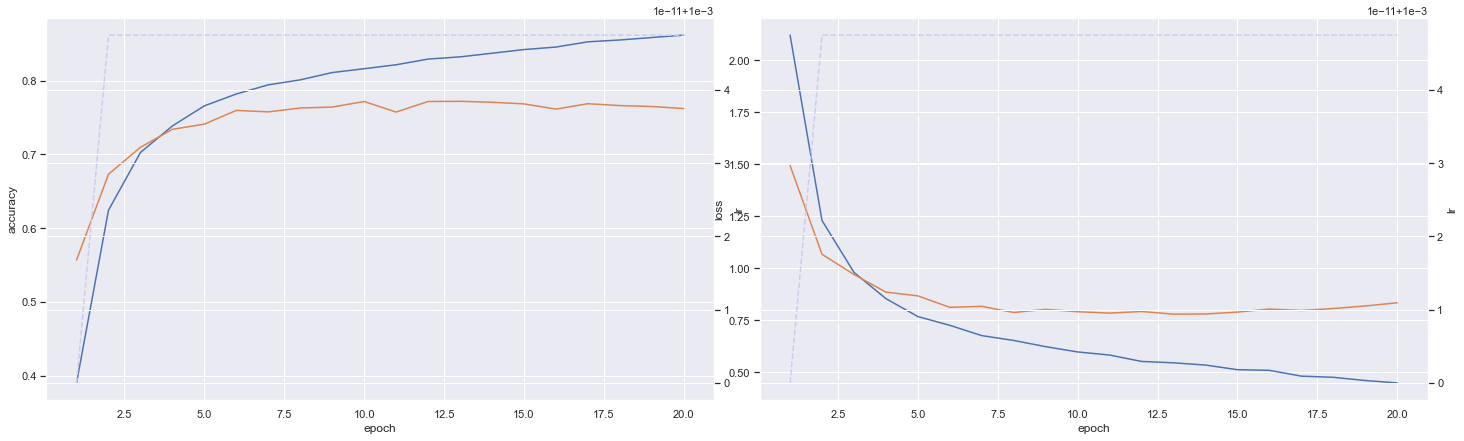

In [93]:
plot_history(model_history(),'model_lstm$')

In [100]:
model_lstm_2 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = False, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [99]:
process_model(model_data, model_lstm_2, label = 'cuisine', model_name = 'model_lstm_2', lr = (5e-5,1e-3),
              epochs = 100, batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 156ms/step - loss: 0.3499 - accuracy: 0.8853 - val_loss: 1.0956 - val_accuracy: 0.7307 - lr: 0.0010


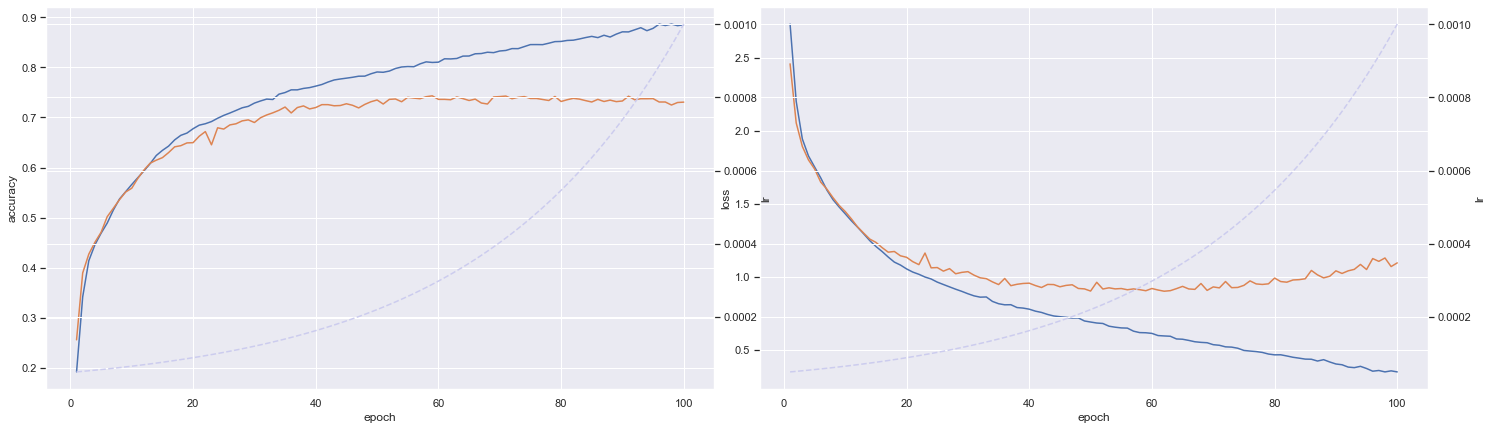

In [94]:
plot_history(model_history(),'model_lstm_2$')

In [ ]:
model_lstm_3 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [162]:
process_model(model_data, model_lstm_3, label = 'cuisine', model_name = 'model_lstm_3', lr = (5e-5,1e-3),
              epochs = 100, batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 159ms/step - loss: 0.1237 - accuracy: 0.9587 - val_loss: 1.7583 - val_accuracy: 0.7362 - lr: 0.0010


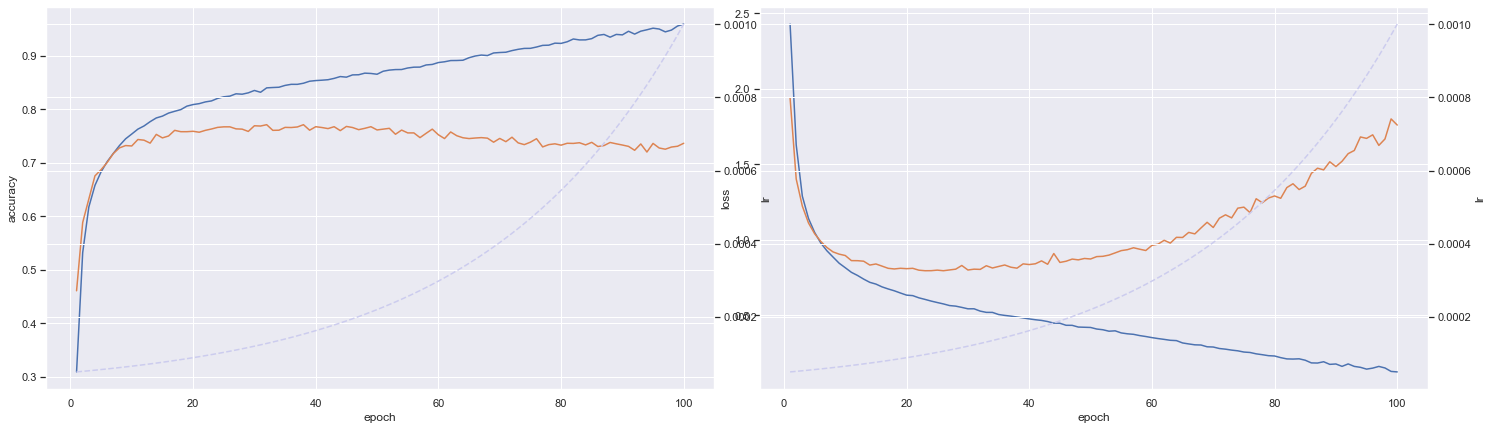

In [97]:
plot_history(model_history(),'model_lstm_3$')

In [118]:
model_lstm_4 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [163]:
process_model(model_data, label = 'cuisine', model_name = 'model_lstm_4', lr = (5e-5,1e-3), epochs = 20,
              batch_size = 256, epoch_subset = 1, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 158ms/step - loss: 0.5669 - accuracy: 0.8236 - val_loss: 0.8260 - val_accuracy: 0.7574 - lr: 0.0010


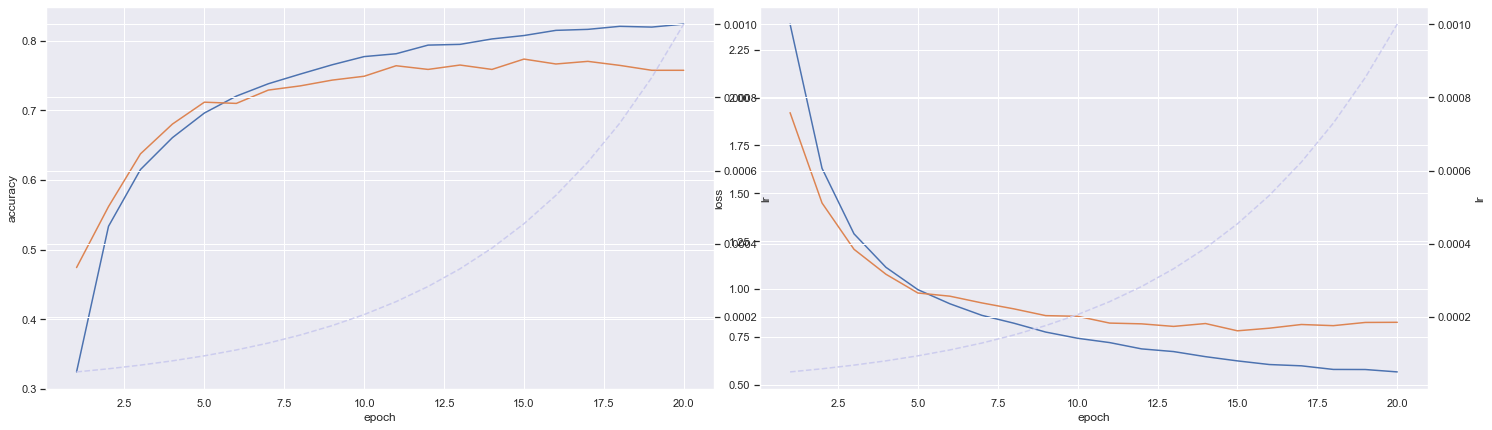

In [96]:
plot_history(model_history(),'model_lstm_4$')

In [ ]:
model_lstm_5 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                           layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [164]:
process_model(model_data, model_lstm_5, label = 'cuisine', model_name = 'model_lstm_5', lr = (5e-5,1e-3),
              epochs = 20, batch_size = 256, epoch_subset = 1, class_weight = True, split_epochs=True)

no model found - initializing
140/140 [==============================] - 22s 159ms/step - loss: 3.8202e-04 - accuracy: 0.7636 - val_loss: 1.0100 - val_accuracy: 0.7000 - lr: 0.0010


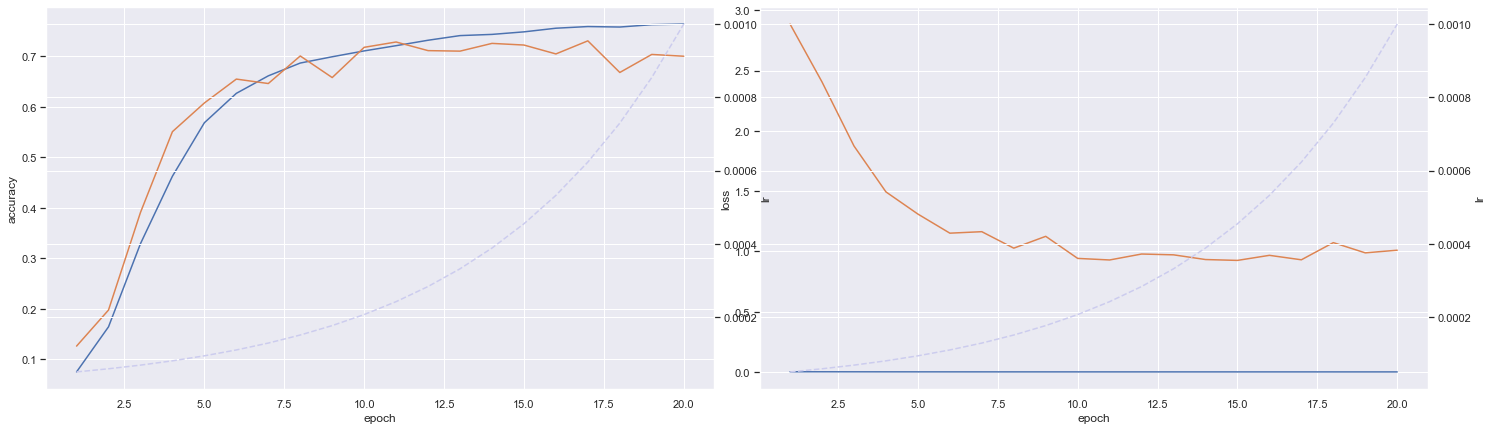

In [119]:
plot_history(model_history(),'model_lstm_5$')

In [ ]:
model_lstm_6 = lstm_model(model_data, loss = 'sparse_categorical_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                          layer_norm = True, categories = 20, activation = 'softmax', metrics=['accuracy'])

In [165]:
process_model(model_data, model_lstm_6, label = 'cuisine', model_name = 'model_lstm_6', lr = (5e-5,1e-3),
              epochs = 20, batch_size = 16, epoch_subset = 1, class_weight = True, split_epochs=True)

no model found - initializing
2238/2238 [==============================] - 122s 54ms/step - loss: 3.7326e-04 - accuracy: 0.7676 - val_loss: 1.1268 - val_accuracy: 0.6809 - lr: 0.0010


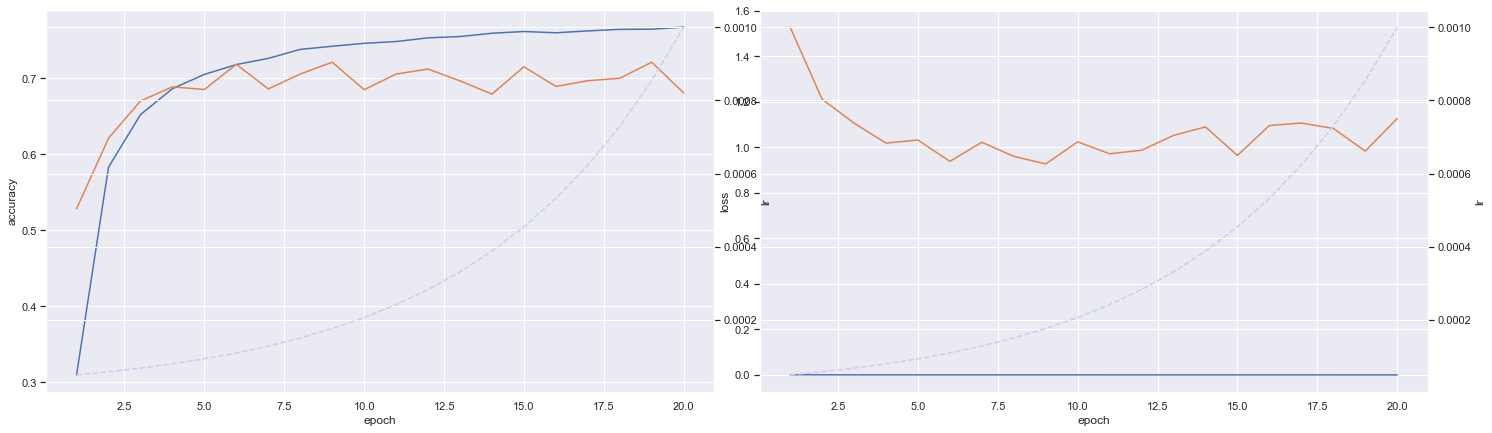

In [351]:
plot_history(model_history(),'model_lstm_6$')

####
####
#### **ONE vs REST BINARY CLASSIFICATION**


Lorem ipsum dolor sit amet

In [199]:
cuisine_groups = list(model_data_onehot['label_encoding'].keys())

In [167]:
model_onehot = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 32,
                          layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
for i,c in enumerate(cuisine_groups):
    process_model(model_data_onehot, model_onehot, label_class = i, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c,
                  lr = (5e-5,1e-3), epochs = 50, batch_size = 64, epoch_subset = 1, split_epochs = True) #, model_path = MODEL_PATH_TEST, history_path = HISTORY_PATH_TEST)

no model found - initializing
560/560 [==============================] - 23s 40ms/step - loss: 0.0125 - accuracy: 0.9958 - auc: 0.9953 - val_loss: 0.1099 - val_accuracy: 0.9799 - val_auc: 0.8910 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 23s 41ms/step - loss: 0.0391 - accuracy: 0.9847 - auc: 0.9963 - val_loss: 0.3220 - val_accuracy: 0.9243 - val_auc: 0.9076 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 42ms/step - loss: 0.0099 - accuracy: 0.9964 - auc: 0.9955 - val_loss: 0.0800 - val_accuracy: 0.9862 - val_auc: 0.8153 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 42ms/step - loss: 0.0123 - accuracy: 0.9953 - auc: 0.9989 - val_loss: 0.1388 - val_accuracy: 0.9703 - val_auc: 0.9500 - lr: 0.0010
no model found - initializing
560/560 [==============================] - 24s 44ms/step - loss: 0.0041 - accuracy: 0.9984 - auc: 0.9998 - val_loss: 0.0498 - val_accuracy

Lets take a look at some of our results here:

In [182]:
hist = model_history()
hist = hist[hist['name'].str.contains('model_lstm_onehot_('+('|'.join(cuisine_groups))+')$')].reset_index(drop=True)

In [183]:
hist[['label','epoch','val_loss','val_auc','val_accuracy']].groupby(['label','epoch']).sum().reset_index()

,label,epoch,val_loss,val_auc,val_accuracy
0,cuisine_brazilian,1,0.062921,0.701884,0.987428
1,cuisine_brazilian,2,0.053329,0.817369,0.987428
2,cuisine_brazilian,3,0.039472,0.889631,0.989439
3,cuisine_brazilian,4,0.036084,0.918319,0.991702
4,cuisine_brazilian,5,0.037096,0.924854,0.990194
...,...,...,...,...,...
995,cuisine_vietnamese,46,0.104217,0.879163,0.982650
996,cuisine_vietnamese,47,0.105945,0.894570,0.976364
997,cuisine_vietnamese,48,0.110108,0.885021,0.982399
998,cuisine_vietnamese,49,0.114913,0.862266,0.981645


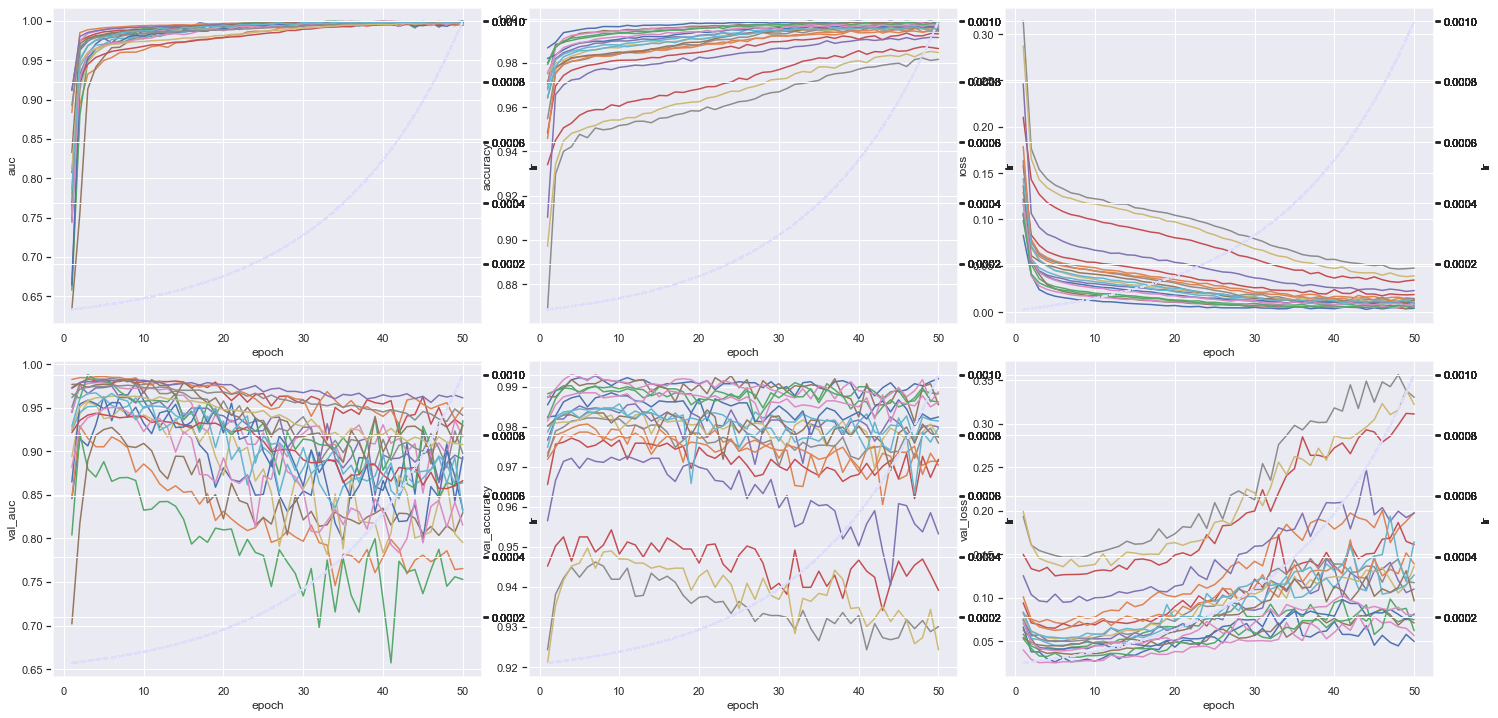

In [184]:
(d1,d2) = (2,3)
fig,axes = plt.subplots(d1, d2, figsize=(20,10))
fig.tight_layout()
fig_metrics = ['auc','accuracy','loss','val_auc','val_accuracy','val_loss']
for p in set(hist['label']):
    data = hist[hist['label']==p]
    for i,j in enumerate(product(range(d1),range(d2))):
        s = sns.lineplot(ax=axes[j[0],j[1]], x = data['epoch'], y = data[fig_metrics[i]])
        s = sns.lineplot(ax=axes[j[0],j[1]].twinx(), x = data['epoch'], y = data['lr'], color='#DDF', linestyle='--')

# fix these scales!
# show the bootstrapped line only

<br>Let's combine our one-hot predictions to get a holistic accuracy score:

In [302]:
preds_onehot = []
#pred_labels = [re.sub('cuisine_','',l) for l in list(set(hist['label']))]
for i,p in enumerate(cuisine_groups):
    m = load_model(MODEL_PATH+'model_lstm_onehot_'+p+'_best.h5')
    preds_onehot.append(m.predict(model_data_onehot['val_data'][i], verbose=0)) #.map(lambda x,y: x[np.newaxis])

In [327]:
preds_onehot_df = pd.DataFrame([[s[0] for s in p] for p in preds_onehot]).transpose()
preds_onehot_df.columns = cuisine_groups
np.round(preds_onehot_df,5)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,0.00033,0.00022,0.00011,0.02568,0.00126,0.00007,0.00007,0.00001,0.00009,0.00714,0.02271,0.00452,0.00008,0.00035,0.00017,0.00054,0.00045,0.00436,0.00011,0.00013
1,0.00061,0.00023,0.00069,0.00065,0.00002,0.00040,0.00243,0.00000,0.00005,0.01135,0.00000,0.00004,0.00001,0.93897,0.00005,0.00083,0.00137,0.00165,0.00000,0.00001
2,0.00065,0.00370,0.07713,0.00026,0.00002,0.01770,0.00774,0.00001,0.04211,0.00006,0.00001,0.00056,0.00001,0.03615,0.00010,0.00491,0.00116,0.00258,0.00000,0.00000
3,0.00056,0.00398,0.00031,0.00649,0.00036,0.00204,0.00565,0.40284,0.00085,0.00346,0.00209,0.03505,0.00336,0.29195,0.00952,0.00358,0.01478,0.00100,0.01069,0.00430
4,0.00076,0.01906,0.00592,0.44077,0.00058,0.02477,0.01606,0.01027,0.01929,0.00189,0.01708,0.00167,0.00184,0.02363,0.00389,0.02148,0.01301,0.00521,0.00209,0.00230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3952,0.84328,0.00223,0.00051,0.00148,0.06030,0.00245,0.00177,0.00119,0.00107,0.03792,0.00452,0.00102,0.00044,0.91299,0.00132,0.00241,0.01565,0.00366,0.00070,0.00456
3953,0.00440,0.02988,0.00649,0.12174,0.00216,0.04092,0.00681,0.06625,0.02056,0.07176,0.00524,0.18040,0.00552,0.09528,0.00251,0.02195,0.03962,0.00676,0.04006,0.02654
3954,0.00276,0.00114,0.00008,0.00257,0.00022,0.03926,0.03869,0.00210,0.00045,0.01168,0.00002,0.00013,0.01257,0.00062,0.00111,0.00360,0.00011,0.00377,0.00320,0.00025
3955,0.00006,0.00045,0.00004,0.16377,0.00013,0.00008,0.00009,0.00694,0.00004,0.00113,0.00061,0.00468,0.00005,0.00001,0.00019,0.00069,0.03437,0.00031,0.00033,0.00013


In [350]:
onehot_pred = np.asarray([np.argmax(preds_onehot_df.iloc[i,:]) for i in range(len(preds_onehot_df))])[np.newaxis]
onehot_real = np.argmax(model_data_onehot['val_labels'],axis=1)[np.newaxis]
onehot_pred_real = pd.DataFrame(np.concatenate([onehot_pred,onehot_real],axis=0).T,columns=['pred','real'])
onehot_pred_real['acc'] = np.where(onehot_pred_real['pred']-onehot_pred_real['real']==0,1,0)
print('Accuracy is:',sum(onehot_pred_real['acc'])/len(onehot_pred_real))

Accuracy is: 0.7842594920794569


#####
#### **Fine Tuning (to be continued)**
Let's just look at one specific label and try and improve the performance for this alone by adjusting the learning rate to be slower and adjusting other parameters:

In [247]:
my_cuisines = ['greek']

for c in my_cuisines:
    model_tune_1 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 128, embedding_dim = 32,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_1, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v2', lr = (1e-6,5e-4),
                  epochs = 100, batch_size = 64, epoch_subset = 1, split_epochs=True)

    model_tune_2 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 512, embedding_dim = 64,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_2, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v3', lr = (1e-5,1e-5),
                  epochs = 20, batch_size = 128, epoch_subset = 1, split_epochs=True)
    
    model_tune_3 = lstm_model(model_data_onehot, loss = 'binary_crossentropy', optimizer = 'adam', rnn_depth = 64, embedding_dim = 6,
                              layer_norm = True, categories = 1, activation = 'sigmoid', metrics=[my_auc,'accuracy'])
    process_model(model_data_onehot, model_tune_3, label_class = 6, label = 'cuisine_'+c, model_name = 'model_lstm_onehot_'+c+'_v3', lr = (1e-5,1e-5),
                  epochs = 20, batch_size = 16, epoch_subset = 1, split_epochs=True)

no model found - initializing
560/560 [==============================] - 32s 58ms/step - loss: 0.0111 - accuracy: 0.9958 - auc: 0.9983 - val_loss: 0.1276 - val_accuracy: 0.9796 - val_auc: 0.8978 - lr: 5.0000e-04


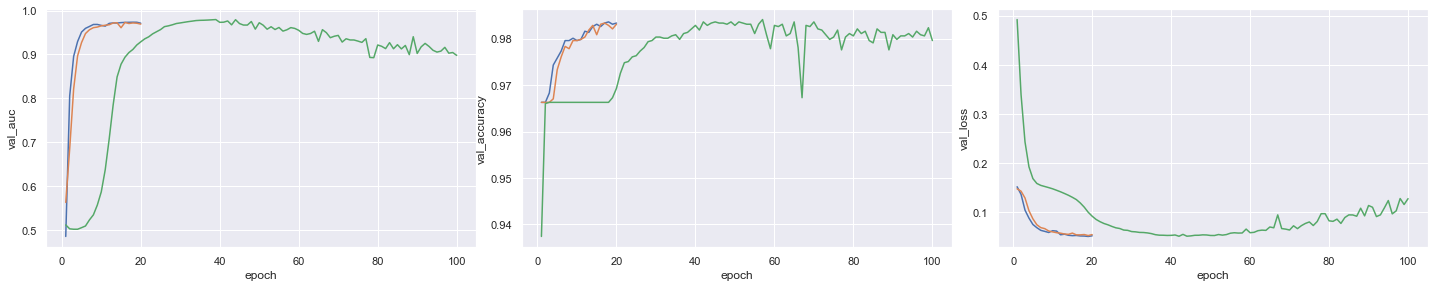

In [185]:
hist = model_history()
hist = hist[hist['name'].str.contains('model_lstm_onehot_('+('|'.join(cuisine_groups))+')_v.$')].reset_index(drop=True)

(d1,d2) = (1,3)
fig,axes = plt.subplots(d1, d2, figsize=(20,4))
fig.tight_layout()
for p in set(hist['name']):
    data = hist[hist['name']==p]
    s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['val_auc'])
    s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['val_accuracy'])
    s = sns.lineplot(ax=axes[2], x = data['epoch'], y = data['val_loss'])

####

####
#### **USING COMPOUND WORD CANDIDATES - REPETITION AND RANDOMIZATION**

This time we'll need to modify the preparation function

In [367]:
np.random.seed(79)
train_df_shuffled = train_df.iloc[:,:3].sample(frac=1).reset_index(drop=True)
if type(train_df_shuffled['ingredients'][0])==str:
    train_df_shuffled['ingredients'] = train_df_shuffled['ingredients'].apply(lambda x: eval(x))
train_df_shuffled.head()

,id,cuisine,ingredients
0,44421,chinese,"[large egg whites, boneless skinless chicken b..."
1,19718,southern_us,"[matzo meal, paprika, ground white pepper, lar..."
2,9055,chinese,"[soy sauce, garlic, hoisin sauce, honey, chine..."
3,5142,mexican,"[yellow bell pepper, red bell pepper, olive oi..."
4,17592,italian,"[water, salt, olive oil, bread flour, active d..."


In [14]:
copies = 20
removal_rate = 0.4

In [275]:
train_df_shuffled['recipe_concat'] = train_df_shuffled['ingredients'].apply(lambda x: ' '.join([re.sub(' ','_',i) for i in x]))
train_df_shuffled['recipe_clean'] = train_df_shuffled['recipe_concat'].apply(lambda x: text_clean(x))

In [278]:
id2 = np.arange(len(train_df_shuffled))
random.shuffle(id2)
id2 = pd.DataFrame(id2,columns=['id2'])
train_df_shuffled = pd.concat([train_df_shuffled,id2],axis=1)

for i in range(copies):
    train_df_shuffled_expanded = train_df_shuffled.copy() if i==0 else train_df_shuffled_expanded.append(train_df_shuffled.copy())
train_df_shuffled_expanded = train_df_shuffled_expanded.sort_values(by='id2').reset_index(drop=True)

In [15]:
def remove_underscores(col,removal_rate):
    c_new = ''
    for c in col:
        if c == '_':
            c_new += (' ' if np.random.random()<removal_rate else '')
        else:
            c_new += c
    return c_new

In [280]:
train_df_shuffled_expanded['recipe_clean'] = train_df_shuffled_expanded['recipe_clean'].apply(lambda x: remove_underscores(x,removal_rate))

In [16]:
# locked in!
try:
    train_df_shuffled_expanded = pd.read_csv('data/train_df_shuffled_expanded.csv')
except:
    train_df_shuffled_expanded.to_csv('data/train_df_shuffled_expanded.csv')

In [17]:
train_df_shuffled_expanded

,Unnamed: 0,id,cuisine,ingredients,recipe_concat,recipe_clean,id2
0,0,25440,southern_us,"['country ham', 'coca-cola']",country_ham coca-cola,countryham coca-cola,0
1,1,25440,southern_us,"['country ham', 'coca-cola']",country_ham coca-cola,countryham coca-cola,0
2,2,25440,southern_us,"['country ham', 'coca-cola']",country_ham coca-cola,countryham coca-cola,0
3,3,25440,southern_us,"['country ham', 'coca-cola']",country_ham coca-cola,country ham coca-cola,0
4,4,25440,southern_us,"['country ham', 'coca-cola']",country_ham coca-cola,countryham coca-cola,0
...,...,...,...,...,...,...,...
791555,791555,9640,japanese,"['seeds', 'garlic', 'ground turmeric', 'water'...",seeds garlic ground_turmeric water lemon oil f...,seeds garlic ground turmeric water lemon oil f...,39577
791556,791556,9640,japanese,"['seeds', 'garlic', 'ground turmeric', 'water'...",seeds garlic ground_turmeric water lemon oil f...,seeds garlic groundturmeric water lemon oil fi...,39577
791557,791557,9640,japanese,"['seeds', 'garlic', 'ground turmeric', 'water'...",seeds garlic ground_turmeric water lemon oil f...,seeds garlic groundturmeric water lemon oil fi...,39577
791558,791558,9640,japanese,"['seeds', 'garlic', 'ground turmeric', 'water'...",seeds garlic ground_turmeric water lemon oil f...,seeds garlic groundturmeric water lemon oil fi...,39577


Once again, we can attempt to use the one-vs-rest approach, alongside a multiclass classifier to see what wins out....

In [18]:
model_data_expanded = text_prepare(train_df_shuffled_expanded[['recipe_clean','id2','cuisine']], num_words = vocab, max_len = 40, encode = 'ordinal')
model_data_onehot_expanded = text_prepare(train_df_shuffled_expanded[['recipe_clean','id2','cuisine']], num_words = vocab, max_len = 40, encode = 'onehot')

In [21]:
# onehot
for i in groups_df['index']:
    model_wrapper_new(
        model_data_onehot_expanded, label = 'cuisine_'+i, model_name = 'model_lstm_onehot_'+i+'_expanded', lr = (5e-6,5e-5), epochs = 20,
        batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, split_epochs = True
    )

In [56]:
# analysis of onehot
for i,j in enumerate(groups_df['index']):
    model_lstm_onehot_expanded_best = load_model('model_data/model_lstm_onehot_'+j+'_expanded_best')
    model_lstm_onehot_expanded_best_preds = model_lstm_onehot_expanded_best.predict(model_data_onehot_expanded['val_padded'])
    preds_df_onehot = pd.DataFrame(model_lstm_onehot_expanded_best_preds,columns=['cuisine_'+j])
    preds_df_onehot_all = copy.deepcopy(preds_df_onehot) if i==0 else pd.concat([preds_df_onehot_all,preds_df_onehot],axis=1)
#preds_df_onehot_all.to_csv('model_data/preds_df_onehot_all.csv',index=False)
best_preds_onehot_max = np.array([np.argmax(x) for x in np.array(preds_df_onehot_all)])
preds_df_onehot = pd.concat([pd.DataFrame(best_preds_onehot_max),pd.DataFrame([re.sub('cuisine_','',list(preds_df_onehot_all.columns)[i]) for i in best_preds_onehot_max]),model_data_onehot_expanded['val'][['cuisine']]],axis=1)
preds_df_onehot.columns = ['pred','pred_name','true_name']
encoder = {}
encoder_df = preds_df_onehot[['pred','pred_name']].drop_duplicates(subset='pred').reset_index(drop=True)
decoder = {}
for i in encoder.keys(): decoder[encoder[i]] = i
for i in range(len(encoder_df)): encoder[encoder_df.iloc[i,:]['pred_name']] = encoder_df.iloc[i,:]['pred']
preds_df_onehot['true'] = preds_df_onehot['true_name'].apply(lambda x: encoder[x])
preds_df_onehot['accuracy'] = preds_df_onehot.apply(lambda r: 1 if r['pred']==r['true'] else 0,axis=1)
print('Accuracy is:',sum(preds_df_onehot['accuracy'])/len(preds_df_onehot))

Accuracy is: 0.7867372123612609


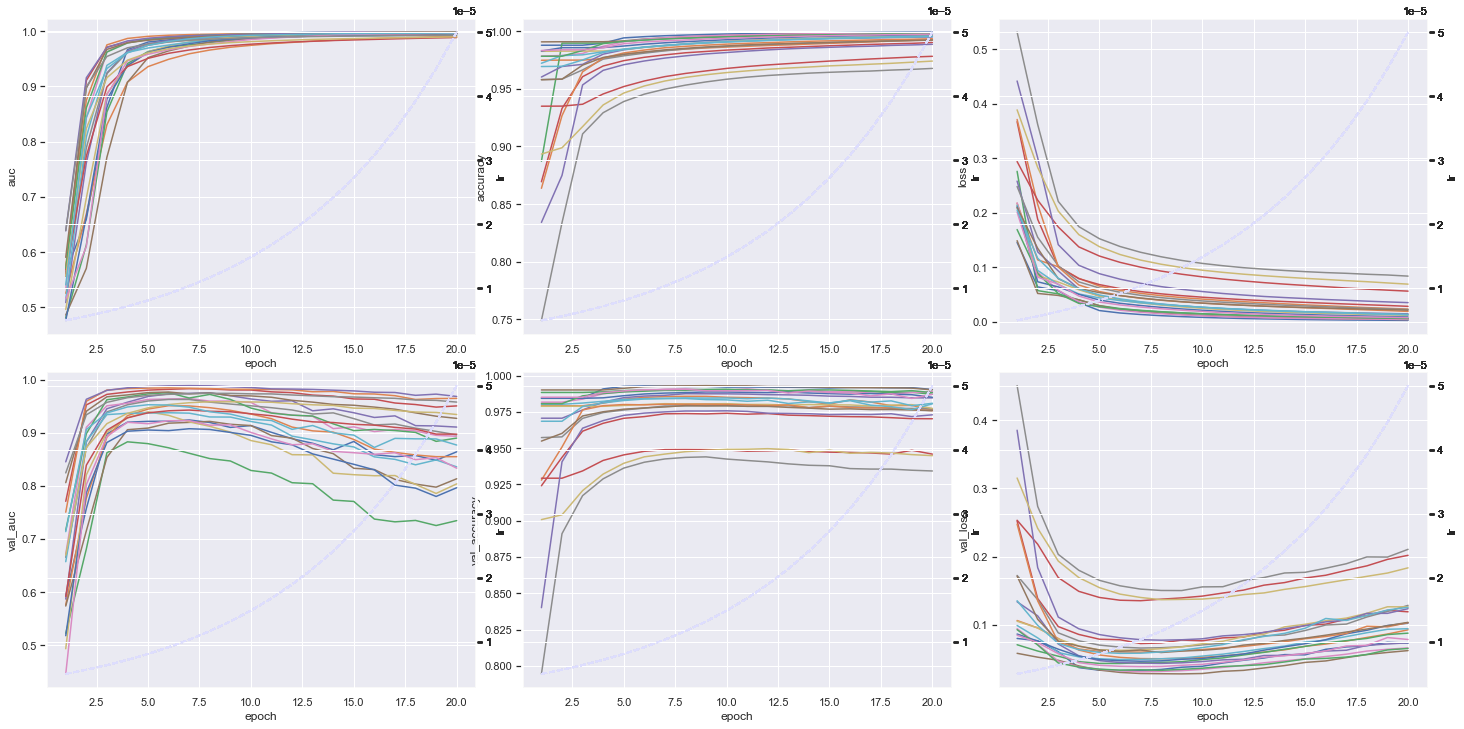

In [130]:
hist = model_history()
hist = hist[hist['name'].str.contains('model_lstm_onehot.*expanded')].reset_index(drop=True)

(d1,d2) = (2,3)
fig,axes = plt.subplots(d1, d2, figsize=(20,10))
fig.tight_layout()
fig_metrics = ['auc','accuracy','loss','val_auc','val_accuracy','val_loss']
for p in set(hist['label']):
    data = hist[hist['label']==p]
    for i,j in enumerate(product(range(d1),range(d2))):
        s = sns.lineplot(ax=axes[j[0],j[1]], x = data['epoch'], y = data[fig_metrics[i]])
        s = sns.lineplot(ax=axes[j[0],j[1]].twinx(), x = data['epoch'], y = data['lr'], color='#DDF', linestyle='--')

In [116]:
preds_pivot(preds_df_onehot[['pred','true','accuracy']], labels = decoder, precision_recall = False)

,greek,southern_us,filipino,indian,jamaican,spanish,italian,mexican,chinese,british,thai,vietnamese,cajun_creole,brazilian,french,japanese,irish,korean,moroccan,russian
index,,,,,,,,,,,,,,,,,,,,
greek,1508.0,74.0,0.0,52.0,0.0,34.0,208.0,13.0,0.0,0.0,0.0,0.0,7.0,0.0,62.0,7.0,0.0,0.0,24.0,1.0
southern_us,28.0,5418.0,27.0,99.0,36.0,64.0,257.0,215.0,6.0,36.0,20.0,0.0,180.0,11.0,245.0,22.0,26.0,1.0,24.0,2.0
filipino,0.0,38.0,655.0,12.0,1.0,1.0,43.0,14.0,37.0,2.0,43.0,48.0,24.0,3.0,16.0,32.0,0.0,38.0,0.0,4.0
indian,1.0,38.0,16.0,4482.0,16.0,18.0,16.0,100.0,3.0,3.0,3.0,0.0,2.0,2.0,47.0,5.0,5.0,0.0,121.0,0.0
jamaican,7.0,63.0,10.0,67.0,739.0,10.0,2.0,32.0,55.0,0.0,0.0,0.0,25.0,3.0,8.0,4.0,4.0,0.0,20.0,0.0
spanish,34.0,23.0,44.0,22.0,0.0,730.0,226.0,78.0,2.0,36.0,0.0,0.0,42.0,8.0,138.0,0.0,0.0,0.0,29.0,0.0
italian,112.0,310.0,0.0,60.0,9.0,79.0,12326.0,121.0,0.0,44.0,0.0,0.0,91.0,0.0,663.0,3.0,27.0,1.0,57.0,8.0
mexican,1.0,226.0,27.0,41.0,21.0,89.0,189.0,10101.0,11.0,8.0,4.0,2.0,8.0,1.0,69.0,3.0,11.0,13.0,5.0,7.0
chinese,0.0,56.0,88.0,30.0,4.0,4.0,112.0,25.0,4365.0,19.0,65.0,54.0,1.0,2.0,27.0,147.0,1.0,136.0,1.0,2.0


In [20]:
# multiclass - complete :)
model_wrapper_new(
    model_data_expanded, label = 'cuisine', model_name = 'model_lstm_expanded', lr = (5e-6,1e-4), epochs = 20, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True
)

In [266]:
# analysis of multiclass - to verify
model_lstm_expanded_best = load_model('model_data/model_lstm_expanded_best')
model_lstm_expanded_best_preds = model_lstm_expanded_best.predict(model_data_expanded['val_padded'])
best_preds_max = np.array([np.argmax(x) for x in model_lstm_expanded_best_preds])
preds_df = pd.concat([pd.DataFrame(np.array(best_preds_max)),model_data_expanded['val'][['cuisine']]],axis=1)
preds_df.columns = ['pred','true']
preds_df['accuracy'] = preds_df.apply(lambda r: 1 if r['pred']==r['true'] else 0,axis=1)
preds_df
print('Accuracy is:',sum(preds_df['accuracy'])/len(preds_df))

2115/2115 [==============================] - 24s 11ms/step
Accuracy is: 0.767007079201336


In [108]:
def preds_pivot(df, labels = None, precision_recall = False):
    preds_pivot = df.groupby(['pred','true']).count().reset_index().pivot(index='true', columns='pred', values='accuracy').fillna(0).reset_index()
    if precision_recall is True:
        preds_pivot['true_positive'] = preds_pivot.apply(lambda r: r[r['true']],axis=1)
        preds_pivot['false_negative'] = preds_pivot.apply(lambda r: sum(r[:20])-r[r['true']],axis=1)
        preds_pivot['recall'] = preds_pivot.apply(lambda r: r[r['true']]/sum(r[:20]),axis=1)
        del preds_pivot['true']
        preds_pivot = preds_pivot.transpose().reset_index()
        preds_pivot1 = preds_pivot.iloc[:20,:]
        preds_pivot2 = preds_pivot.iloc[20:,:]
        preds_pivot1['true_positive'] = preds_pivot1.apply(lambda r: r[r['pred']],axis=1)
        preds_pivot1['false_positive'] = preds_pivot1.apply(lambda r: sum(r[1:21])-r[r['pred']],axis=1)
        preds_pivot1['precison'] = preds_pivot1.apply(lambda r: r[r['pred']]/sum(r[1:21]),axis=1)
        preds_pivot2['true_positive'] = '---'
        preds_pivot2['false_positive'] = '---'
        preds_pivot2['precison'] = '---'
        preds_pivot = preds_pivot1.append(preds_pivot2).set_index('pred').transpose()
    else:
        del preds_pivot['true']
    if labels is not None:
        preds_pivot.columns = [labels[c] for c in preds_pivot.columns]
        preds_pivot = preds_pivot.reset_index()
        preds_pivot['index'] = [labels[c] for c in preds_pivot['index']]
        preds_pivot = preds_pivot.set_index('index')
    return preds_pivot

In [293]:
preds_pivot(preds_df, labels = model_data_expanded['decoder'], precision_recall = False)

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
index,,,,,,,,,,,,,,,,,,,,
brazilian,228.0,8.0,63.0,3.0,32.0,17.0,0.0,22.0,11.0,19.0,18.0,8.0,0.0,109.0,0.0,3.0,99.0,19.0,6.0,7.0
british,7.0,490.0,19.0,0.0,5.0,225.0,16.0,34.0,62.0,56.0,40.0,12.0,16.0,27.0,28.0,44.0,331.0,4.0,16.0,1.0
cajun_creole,7.0,8.0,2063.0,4.0,13.0,139.0,14.0,0.0,0.0,97.0,6.0,0.0,0.0,73.0,0.0,5.0,420.0,38.0,0.0,6.0
chinese,0.0,8.0,2.0,4256.0,88.0,51.0,0.0,14.0,0.0,63.0,0.0,171.0,166.0,17.0,0.0,4.0,59.0,0.0,144.0,96.0
filipino,13.0,10.0,21.0,87.0,526.0,12.0,0.0,9.0,0.0,10.0,0.0,38.0,22.0,50.0,0.0,20.0,65.0,4.0,43.0,81.0
french,0.0,116.0,37.0,42.0,0.0,3060.0,52.0,56.0,71.0,765.0,16.0,44.0,0.0,49.0,22.0,79.0,276.0,101.0,0.0,1.0
greek,0.0,0.0,34.0,0.0,0.0,89.0,1402.0,76.0,0.0,290.0,0.0,0.0,0.0,10.0,19.0,14.0,23.0,28.0,0.0,5.0
indian,6.0,9.0,4.0,2.0,6.0,60.0,17.0,4356.0,30.0,11.0,9.0,68.0,3.0,91.0,84.0,0.0,40.0,19.0,61.0,2.0
irish,0.0,157.0,2.0,5.0,0.0,159.0,11.0,1.0,480.0,79.0,5.0,0.0,2.0,21.0,26.0,1.0,101.0,13.0,0.0,0.0


In [131]:
hist = model_history()
hist = hist[hist['name']=='model_lstm_expanded'].reset_index(drop=True)

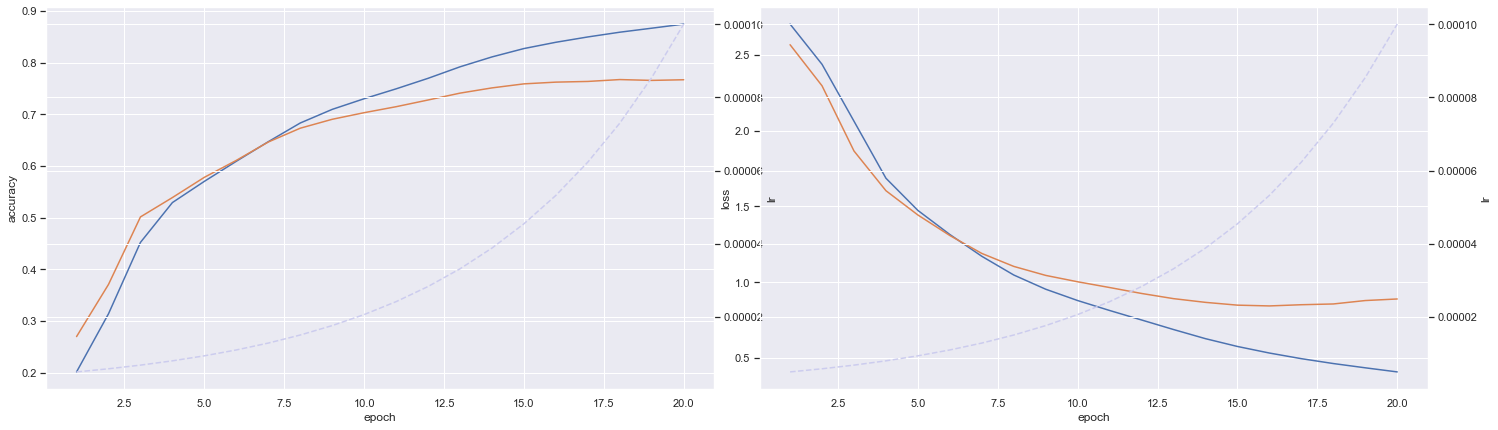

In [133]:
(d1,d2) = (1,2)
fig,axes = plt.subplots(d1, d2, figsize=(20,6))
fig.tight_layout()
for p in set(hist['label']):
    data = hist[hist['label']==p]
    for i in range(d2): s = sns.lineplot(ax=axes[i].twinx(), x = data['epoch'], y = data['lr'], color='#CCE', linestyle='--')
    s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['accuracy'])
    s = sns.lineplot(ax=axes[0], x = data['epoch'], y = data['val_accuracy'])
    s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['loss'])
    s = sns.lineplot(ax=axes[1], x = data['epoch'], y = data['val_loss'])

####

####
#### **REPETITION USING SHUFFLED WORD ORDER**

In [16]:
train_df_shuffled = pd.read_csv('data/train_df_shuffled.csv')
train_df_shuffled['ingredients'] = train_df_shuffled['ingredients'].apply(lambda x: eval(x))

In [17]:
id2 = np.arange(len(train_df_shuffled))
random.shuffle(id2)
id2 = pd.DataFrame(id2,columns=['id2'])
train_df_shuffled = pd.concat([train_df_shuffled,id2],axis=1)

In [18]:
for i in range(40):
    train_df_shuffled2 = train_df_shuffled.copy() if i==0 else train_df_shuffled2.append(train_df_shuffled).reset_index(drop=True)
train_df_shuffled2 = train_df_shuffled2.sort_values(by='id2')

In [19]:
for i in range(len(train_df_shuffled2)):
    np.random.seed(np.random.randint(10000))
    np.random.shuffle(train_df_shuffled2['ingredients'][i])

In [20]:
train_df_shuffled2['ingredients'] = train_df_shuffled2['ingredients'].apply(lambda x: [re.sub(' ','_',w) for w in x])
for i in range(len(train_df_shuffled2)): np.random.shuffle(train_df_shuffled2['ingredients'][i])
train_df_shuffled2['recipe_concat'] = train_df_shuffled2['ingredients'].apply(lambda x: ' '.join(x))
train_df_shuffled2['recipe_clean'] = train_df_shuffled2['recipe_concat'].apply(lambda x: text_clean(x))
train_df_shuffled2['recipe_clean'] = train_df_shuffled2['recipe_clean'].apply(lambda x: remove_underscores(x,removal_rate))
train_df_shuffled2 = train_df_shuffled2.reset_index(drop=True)

In [14]:
#train_df_shuffled2.to_csv('data/train_df_shuffled_expanded2.csv',index=False)
train_df_shuffled2 = pd.read_csv('data/train_df_shuffled_expanded2.csv')

Let us once again attempt multiclass here:

In [34]:
model_data_expanded_shuffled = text_prepare(train_df_shuffled2[['recipe_clean','id2','cuisine']], num_words = vocab, max_len = 40, encode = 'ordinal')

In [370]:
model_wrapper_new(
    model_data_expanded, label = 'cuisine', model_name = 'model_lstm_expanded_shuffled', lr = (5e-6,1e-4), epochs = 20, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True
)

In [369]:
#aggressive lr
model_wrapper_new(
    model_data_expanded_shuffled, label = 'cuisine', model_name = 'model_lstm_expanded_shuffled_v2', lr = (5e-4,1e-2), epochs = 20, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True, stop = 3
)

In [ ]:
#aggressive lr, higher parameters
model_wrapper_new(
    model_data_expanded_shuffled, label = 'cuisine', model_name = 'model_lstm_expanded_shuffled_v3', lr = (5e-4,1e-2), epochs = 20, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 256, embedding_dim = 128, layer_norm = True, multiclass = True, stop = 2
)

In [26]:
#aggressive lr, higher parameters
model_wrapper_new(
    model_data_expanded_shuffled, label = 'cuisine', model_name = 'model_lstm_expanded_shuffled_v4', lr = (5e-4,1e-2), epochs = 100, split_epochs = True,
    batch_size = 512, epoch_subset = 0.01, rnn_depth = 128, embedding_dim = 64, layer_norm = True, multiclass = True, stop = 2
)

no model found - initializing
28/28 [==============================] - 16s 500ms/step - loss: 2.5088 - accuracy: 0.2805 - val_loss: 2.3266 - val_accuracy: 0.3428 - lr: 5.0000e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 15s 499ms/step - loss: 1.7116 - accuracy: 0.5378 - val_loss: 1.8129 - val_accuracy: 0.5020 - lr: 5.1536e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 15s 503ms/step - loss: 1.5672 - accuracy: 0.5604 - val_loss: 1.6388 - val_accuracy: 0.5379 - lr: 5.3119e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 508ms/step - loss: 1.2806 - accuracy: 0.6293 - val_loss: 1.5251 - val_accuracy: 0.5591 - lr: 5.4751e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 15s 503ms/step - loss: 0.9571 - accuracy: 0.7234 - val_loss: 1.4497 - val_accuracy: 0.5967 - lr: 5.6433e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 526ms/step - loss: 1.1023 - accuracy: 0.6836 - val_loss: 1.4521 - val_accuracy: 0.6014 - lr: 5.8167e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 508ms/step - loss: 0.9212 - accuracy: 0.7431 - val_loss: 1.3937 - val_accuracy: 0.6282 - lr: 5.9954e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 521ms/step - loss: 0.8537 - accuracy: 0.7467 - val_loss: 1.3016 - val_accuracy: 0.6398 - lr: 6.1796e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 508ms/step - loss: 0.7977 - accuracy: 0.7740 - val_loss: 1.3264 - val_accuracy: 0.6391 - lr: 6.3695e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
28/28 [==============================] - 16s 513ms/step - loss: 0.6760 - accuracy: 0.8077 - val_loss: 1.3242 - val_accuracy: 0.6405 - lr: 6.5652e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 513ms/step - loss: 0.6998 - accuracy: 0.8116 - val_loss: 1.2891 - val_accuracy: 0.6581 - lr: 6.7669e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 518ms/step - loss: 0.7395 - accuracy: 0.7811 - val_loss: 1.2947 - val_accuracy: 0.6512 - lr: 6.9748e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
28/28 [==============================] - 16s 516ms/step - loss: 0.5947 - accuracy: 0.8351 - val_loss: 1.2876 - val_accuracy: 0.6649 - lr: 7.1890e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
best model saved
28/28 [==============================] - 16s 520ms/step - loss: 0.6310 - accuracy: 0.8203 - val_loss: 1.3457 - val_accuracy: 0.6555 - lr: 7.4099e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved
28/28 [==============================] - 16s 521ms/step - loss: 0.7184 - accuracy: 0.7944 - val_loss: 1.3070 - val_accuracy: 0.6598 - lr: 7.6375e-04


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


INFO:tensorflow:Assets written to: model_data/model_lstm_expanded_shuffled_v4_last/assets


last model saved


In [49]:
#aggressive lr, higher parameters
model_wrapper_new(
    model_data_expanded_shuffled, label = 'cuisine', model_name = 'model_lstm_expanded_shuffled_v5', lr = (5e-4,5e-4), epochs = 40, split_epochs = True,
    batch_size = 64, epoch_subset = 0.025, epoch_subset_val = 0.2, rnn_depth = 1536, embedding_dim = 256, layer_norm = True, multiclass = True,stop = 80
) #, 

40


((array([], shape=(0, 40), dtype=int32), array([], dtype=int64)),
 (array([[   8,  425,  657, ...,    0,    0,    0],
         [  42,  251,   86, ...,    0,    0,    0],
         [  10,   56,   73, ...,    0,    0,    0],
         ...,
         [  48,   17,  111, ...,    0,    0,    0],
         [ 719,   12,  229, ...,    0,    0,    0],
         [ 904,    2, 1844, ...,    0,    0,    0]], dtype=int32),
  array([ 7,  7, 14, ...,  9,  9,  1])))

####
#### **REGULARIZATION AND HYPERPARAMETER TUNING**

In [ ]:
embedding_dim = [8,16,32,64]
rnn_dim = [64,256,1024]
dropout = [0.0,0.2,0.4]
recurrent_dropout = [0.0,0.1,0.2,0.3,0.4,0.5]
kernel_regularizer = [0.0,0.1,0.2,0.3,0.4,0.5]
recurrent_regularizer = [None,'l1','l2','l1_l2']
bias_regularizer = [None,'l1','l2','l1_l2']
activity_regularizer = [None,'l1','l2','l1_l2']

In [ ]:
model_wrapper_new(
    model_data_expanded, label = 'cuisine', model_name = 'model_lstm_expanded', lr = (5e-6,1e-4), epochs = 7, split_epochs = True,
    batch_size = 512, epoch_subset = 1, rnn_depth = 64, embedding_dim = 32, layer_norm = True, multiclass = True
)

####
#### **ATTENTION-BASED METHODS (to do!)**

Lorem ipsum

####
#### **CONCLUSIONS**